We have 125 days EOSUSD data available

lookback_period = 100
correlation_coefficient = 0.8
band_height = 3.5
stop = 0.35  

latest_close = 0
entry_price = 0
wallet = 100
margin = 25
fee = 0 

In [229]:
from threading import Thread
import matplotlib as plt
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy
import math
from scipy.stats import linregress
import numpy as np

In [216]:
import pandas as pd
klineslists = pd.read_csv("./klinelists.csv")

In [217]:
eosusds = klineslists[(klineslists.symbol=="EOSUSD")]
eos_1m = eosusds[(eosusds.interval==1)]
eos_1m = eos_1m.sort_values(by=['open_time'], ascending=True)[250000:]
eos_1m = eos_1m.rename(columns={'open_time': 'timestamp'})

In [218]:
class BattleFieldSituation(object):
    SHORTENTRY = "shortentry"
    LONGENTRY = "longentry"
    SHORTEXIT = "shortexit"
    LONGEXIT = "longexit"

class TradingStrategy(object):
    def __init__(self, klines_list, interval, symbol):
        self._interval = interval
        self._symbol = symbol
        self._klines = self.__check_kline_list(klines_list)

    def __str__(self):
        print("%s:INFO: average volume is %s for symbol %s:" % (__name__, self.average_volume(), self._symbol))
        print("%s:INFO:latest high is %s for symbol %s:" % (__name__, self.latest_high(), self._symbol))
        print("%s:INFO:latest low is %s for symbol %s:" % (__name__, self.latest_low(), self._symbol))
        print("%s:INFO:latest open is %s for symbol %s:" % (__name__, self.latest_open(), self._symbol))
        print("%s:INFO:latest close is %s for symbol %s:" % (__name__, self.latest_close(), self._symbol))
        print("%s:INFO:latest volume is %s for symbol %s:" % (__name__, self.latest_volume(), self._symbol))
        print("%s:INFO:latest timestamp is %s for symbol %s:" % (__name__, self.latest_timestamp(), self._symbol))
        print("%s:INFO:latest volume greater than average is %s for symbol %s:" % (
            __name__, self.latest_volume_greater_than_average(), self._symbol))

    @staticmethod
    def __check_kline_list(klines_list):
        """
        :param klines_list:
        [{
            "open": 10293.0
            "close": 15680.0,
            "high": 15690.0,
            "low": 15670.0,
            "volume": "3",
            "timestamp": 1569041656,
            "interval": "1m"
        }]
        :exception: ValueError:
        WARNING: **WE DO NOT CHECK WHETHER THE LIST IS SORTED :) It's your duty to sort the list in ASC order**
        WELL :) just a joke, we sort it for you base on timestamp
        :return: {list} klines_list
        """
        klines_list = sorted(deepcopy(klines_list), key=lambda k: k["timestamp"])
        if not isinstance(klines_list, list):
            raise ValueError("klines_list is not a list")
        if not 10 <= len(klines_list) <= 5000:
            raise ValueError("kline_list length is not between 10 and 5000")
        for i in klines_list:
            if "open" not in i:
                raise ValueError("Some element in kline_list does not contain \" open \" key")
            if "close" not in i:
                raise ValueError("Some element in kline_list does not contain \" close \" key")
            if "high" not in i:
                raise ValueError("Some element in kline_list does not contain \" high \" key")
            if "low" not in i:
                raise ValueError("Some element in kline_list does not contain \" low \" key")
            if "volume" not in i:
                raise ValueError("Some element in kline_list does not contain \" volume \" key")
            if "timestamp" not in i:
                raise ValueError("Some element in kline_list does not contain \" timestamp \" key")
            if "interval" not in i:
                raise ValueError("Some element in kline_list does not contain \" interval \" key")
        return klines_list

    def latest_high(self):
        return self._klines[-1][("high")]

    def latest_low(self):
        return self._klines[-1]["low"]

    def latest_open(self):
        return self._klines[-1]["open"]

    def latest_close(self):
        return self._klines[-1]["close"]

    def latest_volume(self):
        return self._klines[-1]["volume"]

    def latest_timestamp(self):
        return self._klines[-1]["timestamp"]

    def latest_interval(self):
        return self._klines[-1]["interval"]

    def average_volume(self):
        """
        This function returns the average volume of klines_list,
        :return: float
        """
        volumes = []
        for i in self._klines:
            volumes.append(int(i.get("volume")))
        return float(np.mean(volumes))

    def latest_volume_greater_than_average(self):
        """
        Whether the current volume is greater than the mean volume
        :return: True or False
        """
        last_volume = int(self.latest_volume())
        avg_vol = self.average_volume()

        return True if last_volume > avg_vol else False

    def symbol_name(self):
        return self._symbol

class LinearRegressionStrategy(TradingStrategy):
    _MINIMUM_KLINE_NUMBER = 10
    _MAXIMUM_KLINE_NUMBER = 1000
    _UPPER_BAND_HEIGHT = 1.8
    _LOWER_BAND_HEIGHT = 2
    _STRONG_UPTREND_CORRELATION_COEFFICIENT_LIMIT = 0.3
    _STRONG_DOWNTREND_CORRELATION_COEFFICIENT_LIMIT = -0.3
    _REGRESSION_SOURCE = "close"

    def __init__(self, klines_list, interval, symbol, ub, lb, cor):
        TradingStrategy.__init__(self, klines_list, interval, symbol)
        self._UPPER_BAND_HEIGHT = ub
        self._LOWER_BAND_HEIGHT = lb
        self._STRONG_UPTREND_CORRELATION_COEFFICIENT_LIMIT = cor
        self._STRONG_DOWNTREND_CORRELATION_COEFFICIENT_LIMIT = -cor
        self._dn = float()  # upper deviation: self._reg_m * len(self.klines) + self._reg_c - self._dn
        self._up = float()  # lower deviation: self._reg_m * len(self.klines) + self._reg_c + self._up
        self._reg_m = float()  # factor value
        self._reg_c = float()  # offset value
        self._reg_r = float()  # correlation coefficient value
        self._reg_p = float()  # Pearson value
        self._reg_sd = float()  # standard deviation value
        self.__run()

    def __run(self):
        x_list = range(len(self._klines))
        y_list = []
        for i in self._klines:
            y_list.append(float(i[self._REGRESSION_SOURCE]))

        deviationSum = 0
        slope, intercept, r_value, p_value, std_err = linregress(x_list, y_list)
        for count, i in enumerate(self._klines):
            deviationSum += (float(i[self._REGRESSION_SOURCE]) - (slope * count + intercept)) ** 2
        deviation = math.sqrt(deviationSum / len(self._klines))
        self._dn = deviation * self._UPPER_BAND_HEIGHT
        self._up = deviation * self._LOWER_BAND_HEIGHT
        self._reg_m = slope
        self._reg_c = intercept
        self._reg_r = r_value
        self._reg_p = p_value
        self._reg_sd = std_err

    def __str__(self):
        super().__str__()
        print(
            "%s:INFO: latest upper band price is %s for symbol %s:" % (
                __name__, self.latest_upper_band_price(), self._symbol))
        print(
            "%s:INFO: latest lower band price is %s for symbol %s:" % (
                __name__, self.latest_lower_band_price(), self._symbol))
        print("%s:INFO: is strong uptrend is %s for symbol %s:" % (__name__, self.is_strong_uptrend(), self._symbol))
        print(
            "%s:INFO: is strong downtrend is %s for symbol %s:" % (__name__, self.is_strong_downtrend(), self._symbol))
        print("%s:INFO: Linear Regression Factor is %s for symbol %s:" % (
            __name__, self.regression_factor(), self._symbol))
        print("%s:INFO: Linear Regression Offset is %s for symbol %s:" % (
            __name__, self.regression_offset(), self._symbol))
        print("%s:INFO: Linear Regression Correlation Coefficient is %s for symbol %s:" % (
            __name__, self.regression_correlation_coefficient(), self._symbol))
        print("%s:INFO: Linear Regression Pearson Value is %s for symbol %s: " % (
            __name__, self.regression_pearson_value(), self._symbol))
        print("%s:INFO: Linear Regression Standard Deviation is %s for symbol %s: " % (
            __name__, self.regression_standard_deviation(), self._symbol))
        print("%s:INFO: Linear Regression Upper Band Height is %s for symbol %s: " % (
            __name__, self.regression_upper_band_height(), self._symbol))
        print("%s:INFO: Linear Regression Lower Band Height is %s for symbol %s: " % (
            __name__, self.regression_lower_band_height(), self._symbol))
        print("%s:INFO: Is outside channel is %s for symbol %s:" % (__name__, self.is_outside_channel(), self._symbol))
        print("%s:INFO: Is price higher than upper band is %s for symbol %s:" % (
            __name__, self.is_price_higher_than_upper_band(), self._symbol))
        print("%s:INFO: Is price lower than lower band is %s for symbol %s:" % (
            __name__, self.is_price_lower_than_lower_band(), self._symbol))

    def regression_factor(self):
        return float(self._reg_m)

    def regression_offset(self):
        return float(self._reg_c)

    def regression_correlation_coefficient(self):
        return float(self._reg_r)

    def regression_pearson_value(self):
        return float(self._reg_p)

    def regression_standard_deviation(self):
        return float(self._reg_sd)

    def regression_upper_band_height(self):
        return float(self._up)

    def regression_lower_band_height(self):
        return float(self._dn)

    def latest_upper_band_price(self):
        """
        :return: {float} The Minimum Entry Price of Short Loot, The Upper Band
        """
        return float(self._reg_m * len(self._klines) + self._reg_c + self._up)

    def latest_lower_band_price(self):
        """
        :return: {float} The Maximum Entry Price of Long Loot, The Lower Band
        """
        return float(self._reg_m * len(self._klines) + self._reg_c - self._dn)

    def latest_regression_line_price(self):
        """
        :return: {float} The latest regression line
        """
        return float(self._reg_m * len(self._klines) + self._reg_c)

    def is_strong_uptrend(self):
        """
        Whether the battlefield is in a strong uptrend
        :return: True or False
        """
        if self._reg_r >= self._STRONG_UPTREND_CORRELATION_COEFFICIENT_LIMIT:
            return True
        else:
            return False

    def is_strong_downtrend(self):
        """
        Whether the battlefield is in a strong downtrend
        :return: True or False
        """
        if self._reg_r <= self._STRONG_DOWNTREND_CORRELATION_COEFFICIENT_LIMIT:
            return True
        else:
            return False

    def is_outside_channel(self):
        """
        If close greater than upperband or lower than lowerband
        :return: True or False
        """
        close_price = float(self.latest_close())
        if close_price < self.latest_lower_band_price() or \
                close_price > self.latest_upper_band_price():
            return True
        else:
            return False

    def is_inside_channel(self):
        close_price = float(self.latest_close())
        if close_price > self.latest_lower_band_price() or \
                close_price < self.latest_upper_band_price():
            return True
        else:
            return False

    def is_price_higher_than_upper_band(self):
        close_price = float(self.latest_close())
        if close_price > self.latest_upper_band_price():
            return True
        else:
            return False

    def is_price_lower_than_lower_band(self):
        close_price = float(self.latest_close())
        if close_price < self.latest_lower_band_price():
            return True
        else:
            return False

    def is_price_higher_than_regression_line(self):
        close_price = float(self.latest_close())
        if close_price > self.latest_regression_line_price():
            return True
        else:
            return False

    def is_price_lower_than_regression_line(self):
        close_price = float(self.latest_close())
        if close_price < self.latest_regression_line_price():
            return True
        else:
            return False

class BurningHouseStrategy(LinearRegressionStrategy):

    # noinspection SpellCheckingInspection,PyPep8Naming
    def __init__(self, klines_list, interval, symbol, ub, lb, cor):
        """"
        NOTE: This is a strategy that is well suited for day trading,
        for example, in crypto market, the sensor senses the chaos moment
        in the market and returns some useful info for trading bot to trade
        the ticker
        NOTE: This strategy DOES NOT provide stop loss info, you need to
        calculate the stop loss price according to your leverage.
        CAPABILITY: From 0.02 BTC with 10x to 20x Leverage to up to 100K USD
        :param {list} klines_list:
        [{
            "high": "15690",
            "low": "15670",
            "close": "15680",
            "timestamp": 1569041656,
            "interval": "1m"
            "volume": "3",
        },{...}]
        :param {str} interval
        :param {str} symbol
        """
        LinearRegressionStrategy.__init__(self, deepcopy(klines_list), interval, symbol, ub, lb, cor)

    # noinspection SpellCheckingInspection
    def __str__(self):
        LinearRegressionStrategy.__str__(self)
        print("%s:INFO: Battlefield Situation is %s for symbol %s:" % (
            __name__, self.battlefield_situtation(), self._symbol))
        print("%s:INFO: Latest Exit Price is %s for symbol %s:" % (__name__, self.latest_exit_price(), self._symbol))
        return ""

    # noinspection SpellCheckingInspection
    def battlefield_situtation(self) -> str:
        """
        Whether the sensor saw a fire in battlefield
        """
        if self.is_strong_uptrend() and \
                self.is_outside_channel() and \
                self.is_price_higher_than_upper_band():
            return BattleFieldSituation.SHORTENTRY
        elif self.is_strong_downtrend() and \
                self.is_outside_channel() and \
                self.is_price_lower_than_lower_band():
            return BattleFieldSituation.LONGENTRY
        elif self.is_inside_channel() and \
                self.is_price_higher_than_regression_line():
            return BattleFieldSituation.LONGEXIT
        elif self.is_inside_channel() and \
                self.is_price_lower_than_regression_line():
            return BattleFieldSituation.SHORTEXIT
        else: 
            return None

    def latest_exit_price(self):
        return self.regression_factor() * len(self._klines) + self.regression_offset()

In [469]:
offset = 0
data_feed = eos_1m[offset:4000]
lookback_period = 100
correlation_coefficient = 0.8
band_height = 3.5
stop = 0.35  # 0.3% stop

latest_close = 0
entry_price = 0
wallet = 100
margin = 25
fee = 0  # 0.1% fee

gain = 0
loss = 0
rpnl = 0

position = 'n' # 'l' 's' 'n'
upnl = 0 # unrealized PnL 0%

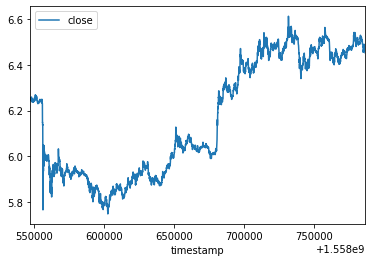

In [470]:
data_feed.plot(x="timestamp", y="close")

In [471]:
for i in range(len(data_feed)-lookback_period-1):
    klines_list=list(data_feed[i:i+lookback_period].T.to_dict().values())
    bhs = BurningHouseStrategy(klines_list=klines_list, interval="1", symbol="EOSUSD", ub=band_height, lb=band_height, cor=correlation_coefficient)
    latest_close = bhs.latest_close()
    
    if position == 'n':
        if bhs.battlefield_situtation() == BattleFieldSituation.SHORTENTRY:
            position = 's'
            entry_price = latest_close
        elif bhs.battlefield_situtation() == BattleFieldSituation.LONGENTRY:
            position = 'l'
            entry_price = latest_close
        else:
            # No trade to make, please wait for pump and dump
            pass 
        
    elif position == 's' or position == 'l':
        if position == 'l':
            upnl = (latest_close - entry_price) / entry_price * 100
        elif position == 's':
            upnl = -(latest_close - entry_price) / entry_price * 100
            
        if upnl >= stop:
            gain+=1
            position='n'
            rpnl += upnl
            wallet = wallet - wallet * margin * fee / 100
            wallet = wallet + wallet * margin * upnl / 100
            wallet = wallet - wallet * margin * fee / 100
        elif upnl <= -stop:
            loss+=1
            position='n'
            rpnl += upnl
            wallet = wallet - wallet * margin * fee / 100
            wallet = wallet + wallet * margin * upnl / 100
            wallet = wallet - wallet * margin * fee / 100

In [472]:
rpnl

0.8889737276285642

In [473]:
gain

3

In [474]:
loss

1

In [475]:
wallet

102.8162766353627